## **Agentic-AI Primer: Introducing Reinforcement Learning (RL)**
### A SIMPLE SPEND OPTIMIZATION USE CASE 

WIP Version: 1 <br>
Last Updated:  2/29/2025 <br>
This workbook is the companion code to this <a href="https://decisionsciences.blog/2025/03/04/workbook-understanding-reinforcement-learning-in-agentic-ai-a-mini-use-case-primer/" target="blank">blog post</a> on decisionsciences.blog</br>

***

## Import Libraries: ##

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import openai
from sqlalchemy import create_engine
from langchain.chat_models import ChatOpenAI  # Correct import for chat models
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.agents import create_openai_functions_agent
from langchain.tools import Tool
from langchain.prompts import PromptTemplate
from langchain.document_loaders import WebBaseLoader
from langchain.document_loaders import UnstructuredURLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import sent_tokenize
import requests
import warnings
import gym
from gym import spaces

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# colors for plotting
ppt_grey = "#5B738B"
ppt_dark_grey = "#666666"
ppt_medium_grey = "#999999"
ppt_lightgrey = "#CCCCCC"
ppt_blue = "#1B90FF"
ppt_red = "#EE3939"
ppt_rasp = "#FA4F96"
ppt_pink = "#F31DED"

## Set View Options: ##

In [6]:
# turn off warnings
import warnings; warnings.simplefilter('ignore')
#set some options for the output
get_ipython().magic(u'matplotlib inline')
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.max_columns', 45) 
pd.set_option('display.max_rows', 40) 
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 240)  # or 199
sns.set_style("whitegrid", {'axes.grid' : False})

In [7]:
#set openai.api_key to the OPEN AI environment (stored in system environment)
openai.api_key = os.environ["OPENAI_API_KEY"]

## Introduction to the Simple Marketing Spend Optimization Model

This notebook demonstrates a basic reinforcement learning (RL) model for optimizing marketing spend. The goal of the model is to find an optimal spend value that maximizes net profit, given that both the revenue generated and the costs incurred depend on the spend level.

### Business Overview:

Imagine you're a marketing team with 10 customer records (e.g., 10 different accounts), and you're trying to figure out the optimal spend on marketing that will maximize your return. The return could be something like revenue or profit generated from each customer based on different spend levels. You use a reinforcement learning model to test different strategies for marketing spend (the agent will choose the spend at each step). The objective is to maximize the return (reward) over time.

The model simulates a simple marketing campaign where we optimize the spend across different marketing actions. The key factors in the model include:
- **Spend**: the amount of money allocated to marketing efforts.
- **Revenue**: a function of the spend, represented by a parabolic curve. The revenue increases as spend increases but then decreases once a certain level of spending is surpassed.
- **Cost**: directly proportional to the amount spent on marketing, with a specified cost factor.

### Objective:
The objective of the model is to `maximize net profit`, which is defined as the difference between the revenue and the cost.

### Reinforcement Learning (RL) Training:

In reinforcement learning, an **agent** interacts with an **environment** by taking actions and observing the resulting **reward** and **new state**. Over many interactions (episodes), the agent gradually learns which actions lead to higher rewards. This process is driven by a **policy**, which maps states to actions. The RL algorithm updates this policy based on the feedback (rewards) it receives, aiming to maximize the cumulative reward over time.

Concretely, the agent starts with little or no knowledge about which actions are best. By trying different actions and observing their outcomes, it **explores** the environment. As it collects experience, it **exploits** what it has learned by choosing actions that yielded higher rewards in the past. This **exploration vs. exploitation** balance is central to RL: the agent must try new actions to discover better strategies while also using known successful actions to gain higher rewards.

---


### Understanding the Parabolic Revenue Function:

In our model, revenue follows a `simple parabolic function` that has a peak at a spend value of 5.0, as shown in the following equation:

$
\text{Revenue} = -(s - 5)^2 + 25
$

Where:
- $( s $) is the spend level.
- The revenue decreases as the spend moves further from 5.

This function captures the idea that while higher spending may initially increase revenue, beyond a certain point, the return on investment decreases.

### Why a Parabolic Function?
This model assumes `diminishing returns` on marketing spend, where too much spend leads to inefficiency. For example:
- **Under-spending** may miss opportunities to reach potential customers.
- **Over-spending** leads to inefficient allocation and diminishing returns.

The goal is to find the optimal balance that `maximizes net profit`.


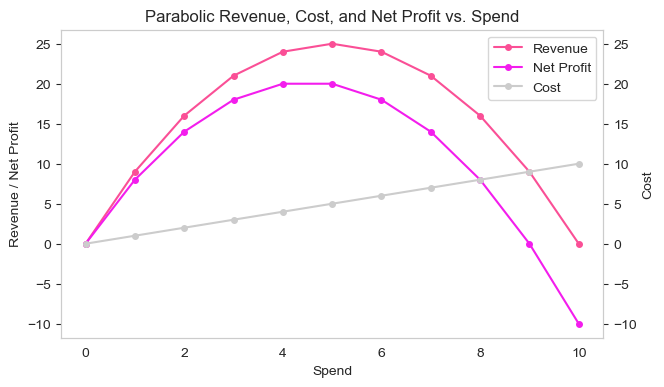

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Generate data
spend_values = np.arange(0, 11, 1)
revenue = -(spend_values - 5)**2 + 25
cost = spend_values * 1.0
net_profit = revenue - cost

# 2) Create the figure and two axes
fig, ax1 = plt.subplots(figsize=(7, 4))

# 'ax2' will share the same x-axis but can have a separate y-axis
ax2 = ax1.twinx()

# 3) Plot revenue and net profit on ax1
lns1 = ax1.plot(spend_values, revenue, label="Revenue", marker='o', markersize=4, color=ppt_rasp)
lns2 = ax1.plot(spend_values, net_profit, label="Net Profit", marker='o', markersize=4, color=ppt_pink)

# 4) Plot cost on ax2
# (Choose a distinct color or re-use your palette as needed)
lns3 = ax2.plot(spend_values, cost, label="Cost", marker='o', markersize=4,color=ppt_lightgrey)

# 5) Force ax2 to match ax1's y-limits so they share the same numeric scale
ax2.set_ylim(ax1.get_ylim())

# 6) Combine legends from both axes
lines = lns1 + lns2 + lns3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="best")

# 7) Label the axes
ax1.set_xlabel("Spend")
ax1.set_ylabel("Revenue / Net Profit")
ax2.set_ylabel("Cost")

# 8) Add title and show
plt.title("Parabolic Revenue, Cost, and Net Profit vs. Spend")
plt.show()


#### What This Plot Shows:
- Revenue: peaks at spend = 5 (where it hits 25).
- Cost: increases linearly with spend (cost factor = 1.0).
- Net Profit: the difference between revenue and cost, reaching its `maximum at spend 4 or 5 (net profit=20)`.

This visualization confirms the `theoretical sweet spot` for spending, which the RL agent should ideally discover through trial and error.

### Generate Simple Dataset
The code below defines a function called `generate_simple_dataset` that creates a dataset of spend levels and their corresponding revenue, cost, and net profit values based on a `simple parabolic revenue function`.

In [13]:
def generate_simple_dataset(max_spend=10, cost_factor=1.0):
    data = []
    for s in range(max_spend+1):
        revenue = - (s - 5)**2 + 25
        cost = s * cost_factor
        net_profit = revenue - cost
        data.append({
            "spend": s,
            "revenue": revenue,
            "cost": cost,
            "net_profit": net_profit
        })
    return data

# Example usage:
dataset = generate_simple_dataset(max_spend=10, cost_factor=1.0)
for row in dataset:
    print(row)


{'spend': 0, 'revenue': 0, 'cost': 0.0, 'net_profit': 0.0}
{'spend': 1, 'revenue': 9, 'cost': 1.0, 'net_profit': 8.0}
{'spend': 2, 'revenue': 16, 'cost': 2.0, 'net_profit': 14.0}
{'spend': 3, 'revenue': 21, 'cost': 3.0, 'net_profit': 18.0}
{'spend': 4, 'revenue': 24, 'cost': 4.0, 'net_profit': 20.0}
{'spend': 5, 'revenue': 25, 'cost': 5.0, 'net_profit': 20.0}
{'spend': 6, 'revenue': 24, 'cost': 6.0, 'net_profit': 18.0}
{'spend': 7, 'revenue': 21, 'cost': 7.0, 'net_profit': 14.0}
{'spend': 8, 'revenue': 16, 'cost': 8.0, 'net_profit': 8.0}
{'spend': 9, 'revenue': 9, 'cost': 9.0, 'net_profit': 0.0}
{'spend': 10, 'revenue': 0, 'cost': 10.0, 'net_profit': -10.0}


## The Environment: SimpleMarketingEnv Class

OpenAI Gym is a widely used library in reinforcement learning (RL) that provides a standard interface for different “environments.” The environment is a custom environment (`SimpleMarketingEnv`) that simulates the marketing spend problem. 

We have created a `small, simplified environment` with `known properties`— so that we can more `easily diagnose your RL agent’s behavior`. The idea is to make the `dynamics and optimal policy very clear`, which helps us confirm whether the RL agent (like PPO) is truly learning the right strategy.

Note: when you call `model.predict(obs, deterministic=True)`, you’re forcing the policy to pick the most likely (or “greedy”) action. It might always choose action 0 in that scenario, even if the policy occasionally picks other actions in a stochastic setting.

Below is an overview of how the environment is set up:

**Steps:**
1. **Environment Setup**  
   We’ll create a minimal environment with a `single state variable`: `marketing_spend`.  
2. **Reward Function**  
   We’ll define a `known` function for revenue (with diminishing returns) and subtract a simple cost for spending.  
3. **Small Action Space**  
   Actions are discrete: **\[0 = no change, 1 = increase spend by 1, 2 = decrease spend by 1\]**.  
4. **Short Episode**  
   We limit each episode to a small number of steps (e.g., 10).  
5. **Known Optimal Spend**  
   We’ll pick function parameters so that we know the best spend level in theory, which the RL agent should discover.

By controlling these elements, we can easily see if the agent is converging on the known optimal strategy.

---

### **Actions the RL Agent Can Take**:

The RL agent can take **three possible actions** at each step:

- **Action 0 (No Change)**:  
  - The agent decides to `keep the spend level the same`.
  - The `spend` remains unchanged, and the agent receives a reward based on the current spend.
  <br>
- **Action 1 (Increase Spend by 1)**:  
  - The agent decides to `increase the marketing spend by 1`.
  - The `spend` goes up by 1 unit (within the range [0, max_spend]), and the agent receives a reward based on the new spend.
 <br>
- **Action 2 (Decrease Spend by 1)**:  
  - The agent decides to `decrease the marketing spend by 1`.
  - The `spend` goes down by 1 unit (within the range [0, max_spend]), and the agent receives a reward based on the new spend.
---

### **The Objective (i.e. Return) the Agent Is Trying to Optimize**:

The **objective** the agent is optimizing is the **total return**, which is based on the **net profit** the agent earns at each step. The net profit for each action is calculated using the formula: <br></br>
$
\text{Net Profit} = \text{Revenue} - \text{Cost}
$

Where: 
- `Revenue` is determined by a simple `parabolic` formula: &nbsp;
  $
  \text{Revenue} = -(s - 5)^2 + 25
  $   <br>
  Here, $(s$) is the spend, and the revenue is highest when spend is 5 (reaching 25). As spend moves away from 5, revenue decreases.
- `Cost` is simply the `spend multiplied by a cost factor`: &nbsp;
  $
  \text{Cost} = \text{spend} \times \text{cost factor}
  $   <br>

The `reward` (return) for each action is the difference between `revenue` and `cost`: &nbsp;
$
\text{Reward} = \text{Revenue} - \text{Cost}
$
 <br>
The agent tries to `maximize this reward`, as it represents the `net profit` from each step.

---

### **Goal**:

The goal of the RL agent is to `determine the optimal marketing spend` (within the possible range) to `maximize net profit` over time. 

In our simplified environment:
- The agent `optimizes the spend` (in increments of 1) to achieve the highest `net profit`.
- The optimal spend is at `4` or `5`, where net profit is maximized at 20.

Thus, the `optimal policy` the agent is learning is the strategy that maximizes the `reward` (net profit) over the 10 steps (or time periods) in the episode.


## Base Environment (Gym)

In [18]:
import gym
from gym import spaces
from gym.utils import seeding

class SimpleMarketingEnv(gym.Env):
    def __init__(self, max_spend=10, cost_factor=1.0, max_steps=10, seed=None):
        super().__init__()
        self.max_spend = max_spend
        self.cost_factor = cost_factor
        self.max_steps = max_steps

        self.observation_space = spaces.Box(
            low=np.array([0], dtype=np.float32),
            high=np.array([float(max_spend)], dtype=np.float32),
            shape=(1,),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)

        self.state = None
        self.current_step = 0
        # Call our custom seed method (defined below)
        self.seed(seed)

    def seed(self, seed=None):
        """
        Sets the seed for this environment's random number generator(s).
        If 'seed' is None, a random seed is chosen.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0

        # Start at a random spend from 0..max_spend using the new .integers(...) method
        initial_spend = self.np_random.integers(0, self.max_spend + 1)
        self.state = np.array([float(initial_spend)], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        spend = self.state[0]

        # Update spend based on action
        if action == 1:  # +1
            spend += 1
        elif action == 2:  # -1
            spend -= 1
        spend = float(np.clip(spend, 0, self.max_spend))

        # Simple parabola revenue = -(s - 5)^2 + 25
        revenue = -(spend - 5)**2 + 25
        cost = spend * self.cost_factor
        reward = revenue - cost

        self.state = np.array([spend], dtype=np.float32)
        self.current_step += 1
        done = False
        truncated = (self.current_step >= self.max_steps)
        return self.state, reward, done, truncated, {}

    def render(self):
        print(f"Step {self.current_step}, Spend={self.state[0]}")


The code above defines a `custom reinforcement learning environment (SimpleMarketingEnv)`, which is commonly used for building environments for RL agents.

- **Summary:**
  - This code defines a `simple marketing environment` where an agent can adjust a budget (spend) within a given range.
  - The `agent performs actions` (increase, decrease, or stay the same) to maximize the reward, which is based on balancing revenue and cost.
  - The environment `tracks the agent's spend`, `calculates the resulting revenue and cost`, and `rewards` the agent based on these factors.
  - The environment also `keeps track of the number of steps` in an episode and terminates when the max_steps limit is reached.


In [20]:
# Subclass that prints each step during training
class VerboseEnv(SimpleMarketingEnv):
    def step(self, action):
        old_spend = self.state[0]
        obs, reward, done, truncated, info = super().step(action)
        new_spend = obs[0]
        # PRINT or log the action taken and reward
        print(f"[Training Step {self.current_step}] old_spend={old_spend}, action={action}, "
              f"reward={reward:.2f}, new_spend={new_spend}")
        return obs, reward, done, truncated, info

The `VerboseEnv` class above  is a `subclass of SimpleMarketingEnv`. It inherits all the functionality of SimpleMarketingEnv but overrides the step method to add additional logging of the agent’s actions and rewards, including additional print statements for tracking and logging during training.

##### Logging: A print statement logs the following information:
- The current training step (self.current_step).
- The old spend value before the action (old_spend).
- The action taken by the agent (action).
- The reward earned for that action (reward, formatted to two decimal places).
- The new spend value after the action (new_spend).

## Train & Evaluate Simple RL Model

The code below demonstrates the process of `training a reinforcement learning agent` using the `Proximal Policy Optimization (PPO) algorithm` from the `stable_baselines3` library, applied to a simple marketing environment (SimpleMarketingEnv). The training process involves the agent learning how to maximize rewards (in this case, net profit) by adjusting its spending. 

- **Creating the environment:** the function `train_simple_ppo` creates an instance of the `SimpleMarketingEnv` environment with parameters:
  - `max_spend=10`: maximum spending allowed is 10.
  - `cost_factor=1.0`: the factor used to calculate cost based on spending.
  - `max_steps=10`: maximum number of steps (or actions) per episode.
<br></br>
- **Initializing PPO model:** The PPO model is initialized with the following:
  - `"MlpPolicy"`: specifies the type of policy to use, in this case, a `multilayer perceptron (MLP) policy`, which uses a `neural network` for decision-making.
  - `env:` the environment that the agent will interact with.
  - `verbose=1`: provides detailed logs during training.
<br></br>
- **Training the model:** the agent is trained using `the model.learn() method`, which runs for `total_timesteps (10,000 in the example)`. The agent interacts with the environment during this time and `learns to optimize its behavior to maximize rewards`.
<br></br>
- **Evaluating the model:** after training, the performance of the agent is evaluated using the `evaluate_policy function`:
  - `model`: the trained PPO model.
  - `test_env`: a `new instance` of the environment for evaluation.
  - `n_eval_episodes=5`: the agent is `evaluated over 5 episodes`.
  - `deterministic=True`: ensures that the agent follows a deterministic policy during evaluation (`no randomness` in action selection).

In [24]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Function to train the agent
def train_simple_ppo(total_timesteps=10_000):
    env = SimpleMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=10, seed=42)
    model = PPO("MlpPolicy", env, verbose=1, seed=42)
    model.learn(total_timesteps=total_timesteps)
    return model

if __name__ == "__main__":
    # Train the agent
    model = train_simple_ppo(total_timesteps=10000)
    
    # Evaluate the trained agent
    test_env = SimpleMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=10, seed=42)
    mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=5, deterministic=True)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 109      |
| time/              |          |
|    fps             | 418      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 93          |
| time/                   |             |
|    fps                  | 251         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009150444 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss   

#### RESULT:
Below is a **short explanation** of how to interpret each part of the **training logs** and the **final evaluation**:

1. **Iterations and Timesteps**
   - Each “iteration” in the logs corresponds to one cycle of PPO collecting `2048` steps of experience, then performing an update. The line `total_timesteps` shows the `cumulative` number of environment steps so far (e.g., 4096 after the second iteration).
<br></br>
3. **rollout/ Metrics**  
   - `ep_len_mean (10)`: each episode lasts 10 steps on average. Because the environment has `max_steps=10`, it means every episode hits that max step count before resetting.  
   - `ep_rew_mean`: the `average episode reward` (sum of rewards over those 10 steps), computed across all episodes in that iteration. We see it `rising` from ~93 to ~164 across iterations, indicating `learning` progress (the agent is finding more rewarding policies over time).
<br></br>
4. **time/ Metrics**  
   - `fps`: frames (or steps) per second—how quickly PPO is training.  
   - `iterations`: the number of PPO update cycles completed.  
   - `time_elapsed`: how many real-time seconds have passed since training began.
<br></br>
5. **train/ Metrics**  
   - `approx_kl`: an estimate of the `KL divergence` between the new and old policy (used by PPO to limit large updates).  
   - `clip_fraction`: the fraction of actions that get clipped by the PPO objective. Lower values suggest fewer extreme policy updates.  
   - `entropy_loss`: a measure of policy “randomness.” Higher entropy can indicate more exploration.  
   - `explained_variance`: how well the value function predicts returns. Near 0 (or negative) means it’s not explaining much variance, whereas values near 1 mean good fit.  
   - `policy_gradient_loss` and `value_loss`: loss terms for the policy and value networks. They’re mainly useful for debugging or checking if the losses are blowing up.  
   - `n_updates`: how many times the PPO optimizer has run so far.
<br></br>

**Final Evaluation**  
   - `"Mean reward: 194.00 +/- 7.59”` means that when you `evaluate` the final policy over a few episodes (i.e. `n_eval_episodes=5`), it achieves an `average` total episode reward of ~194, with a standard deviation of ~7.59.  
   - Since the `maximum` possible reward (if the agent gets a net profit of 20 each step for 10 steps) is 200, scoring 194 suggests the agent is very close to `optimal` performance in this environment.
<br></br>

**In short**, the logs show the agent’s `episode reward` increasing iteration by iteration, indicating that PPO is learning a `better` policy. By the end, the `mean episode reward` of 194 out of a possible 200 indicates the agent has nearly converged to the `best` strategy.

---

#### Note:
An **explained variance near zero (0.0029)** typically indicates that the `value function` isn’t predicting returns particularly well. However, our agent can still `perform well overall` (as indicated by the high episode rewards) for a few reasons:

1. `Short Episodes`: in a 10-step environment, most of the reward might come near the end, so the returns can be harder for the value network to predict accurately in the early steps.

2. `Discrete or Parabolic Rewards`: If the reward structure is simple or somewhat discontinuous (like jumping from 18 to 20 points at certain spends), a basic value function might not capture it smoothly—even if the `policy` (which picks the actions) is near-optimal.

3. `Policy vs. Value Function`: PPO uses both a policy network and a value network, but if the policy is learning a near-perfect strategy quickly, it may not rely heavily on a finely tuned value function. So, you can see `high episode rewards` while the value loss and explained variance remain suboptimal.

In other words, `low explained variance` doesn’t automatically mean the policy is bad—it just means the `value function` isn’t closely modeling the return. Since your `ep_rew_mean` is close to the theoretical max, the agent is clearly learning a `good policy`, despite the value function’s imperfect predictions.


## Logging each step: 
- Below is a small function you can use to verify exactly which spend levels and actions the agent is taking:
- The format of the output is: episode, step, spend_before, action, reward, spend_after

In [28]:
def log_agent_trajectory(model, env, n_episodes=1, deterministic=True):
    """
    Runs the model in the environment for n_episodes,
    logging each step: (episode, step, spend_before, action, reward, spend_after).
    Returns a list of logs.
    """
    logs = []
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        step = 0
        episode_reward = 0.0
        
        while not (done or truncated):
            action, _states = model.predict(obs, deterministic=deterministic)
            next_obs, reward, done, truncated, info = env.step(action)
            
            # obs[0] = spend before action
            # next_obs[0] = spend after action
            logs.append((ep, step, obs[0], int(action), reward, next_obs[0]))
            
            obs = next_obs
            episode_reward += reward
            step += 1
        
        print(f"Episode {ep} total reward: {episode_reward:.2f}")
    
    return logs


In [29]:
model = PPO.load("my_simple_ppo_model")
env = SimpleMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=10, seed=42)

logs = log_agent_trajectory(model, env, n_episodes=3, deterministic=True)

# Print a few lines
for row in logs:
    print(row)


Episode 0 total reward: 180.00
Episode 1 total reward: 192.00
Episode 2 total reward: 198.00
(0, 0, 0.0, 1, 8.0, 1.0)
(0, 1, 1.0, 1, 14.0, 2.0)
(0, 2, 2.0, 1, 18.0, 3.0)
(0, 3, 3.0, 1, 20.0, 4.0)
(0, 4, 4.0, 1, 20.0, 5.0)
(0, 5, 5.0, 2, 20.0, 4.0)
(0, 6, 4.0, 1, 20.0, 5.0)
(0, 7, 5.0, 2, 20.0, 4.0)
(0, 8, 4.0, 1, 20.0, 5.0)
(0, 9, 5.0, 2, 20.0, 4.0)
(1, 0, 8.0, 2, 14.0, 7.0)
(1, 1, 7.0, 2, 18.0, 6.0)
(1, 2, 6.0, 2, 20.0, 5.0)
(1, 3, 5.0, 2, 20.0, 4.0)
(1, 4, 4.0, 1, 20.0, 5.0)
(1, 5, 5.0, 2, 20.0, 4.0)
(1, 6, 4.0, 1, 20.0, 5.0)
(1, 7, 5.0, 2, 20.0, 4.0)
(1, 8, 4.0, 1, 20.0, 5.0)
(1, 9, 5.0, 2, 20.0, 4.0)
(2, 0, 7.0, 2, 18.0, 6.0)
(2, 1, 6.0, 2, 20.0, 5.0)
(2, 2, 5.0, 2, 20.0, 4.0)
(2, 3, 4.0, 1, 20.0, 5.0)
(2, 4, 5.0, 2, 20.0, 4.0)
(2, 5, 4.0, 1, 20.0, 5.0)
(2, 6, 5.0, 2, 20.0, 4.0)
(2, 7, 4.0, 1, 20.0, 5.0)
(2, 8, 5.0, 2, 20.0, 4.0)
(2, 9, 4.0, 1, 20.0, 5.0)


The output you're seeing represents the results of running the **reinforcement learning agent** over **3 episodes** used to **evaluate** the model, with **step-by-step rewards** for each of the 10 steps in each episode. Let's break it down:

1. **Episode X total reward**
   - You have three episodes—0, 1, and 2—each with a `total reward`. For example, “Episode 0 total reward: 180.00” means that `across all 10 steps` of episode 0, the agent accumulated a reward of `180`.
<br></br>
2. **Line-by-Line Tuples**  
   Each tuple looks like:
   ```
   (episode_index, step_index, old_spend, action, reward, new_spend)
   ```
   - `episode_index` (e.g., 0, 1, 2): Which episode this step belongs to.  
   - `step_index` (0 through 9): The step number within that episode.  
   - `old_spend`: the spend level *before* the agent took an action this step.  
   - `action`: the discrete action the agent chose (e.g., 1 = increase, 2 = decrease, 0 = stay).  
   - `reward`: the immediate reward (net profit) received from taking that action at this step.  
   - `new_spend`: The spend level after applying the action.
<br></br>
3. **Reading an Example Row**  
   Take `(0, 2, 2.0, 1, 18.0, 3.0)`:
   - `Episode 0`, `Step 2`  
   - `old_spend` = 2.0  
   - `action` = 1 (agent decides to increase spend by 1)  
   - `reward` = 18.0 (the net profit from that step)  
   - `new_spend` = 3.0 (the agent’s spend level after the action)
<br></br>
4. **How the Agent Moves Spend**  
   - You’ll notice from these lines that if `old_spend` is below 5, the agent often `increases` it (action=1), raising net profit until it hits 4 or 5 (where reward = 20).  
   - If `old_spend` is above 5, the agent typically `decreases` it (action=2) to move closer to 5, again yielding higher net profit.
<br></br>
5. **Summing Rewards**  
   - The “Episode X total reward” is simply the `sum` of all `reward` values in the tuples for that episode. For instance, episode 0’s line-by-line rewards add up to `180`.
<br></br>
6. **Observing Improvement**  
   - `Episode 0` total reward: `180.00`  
   - `Episode 1` total reward: `192.00`  
   - `Episode 2` total reward: `198.00`  
   These rising totals suggest that each episode started in a different (possibly more advantageous) state or that the agent’s policy is consistently steering spend toward the profit-maximizing region (spend=4 or 5) more quickly, yielding a higher overall return each time.

**In Short**:  
- `Each tuple` details a single step: (episode, step, old_spend, action, reward, new_spend).  
- `Total reward` is the sum of the rewards for the 10 steps in that episode.  
- `Spending` typically converges to `4 or 5` (reward=20), maximizing net profit.  
- The `increasing total reward` across episodes (180 → 192 → 198) indicates the agent is `performing better` each time it starts from a new initial condition.
---

## Show Learning Process During Model Training:
The output below is the `detailed training log` of the agent's interactions with the environment during the `training phase`. It's showing how the agent makes decisions step by step during its learning process, along with the corresponding rewards and updates to the spend.:

#### Key Elements in This Output:
- `Old Spend`: the amount of budget (or "spend") before the agent makes a decision.
- `Action`: the action taken by the agent (e.g., `0 = keep`, `1 = increase`, `2 = decrease`).
- `Reward`: the reward received after the action is taken (based on the environment's feedback to the action).
- `New Spend`: the amount of budget (or "spend") after the action has been executed.

In [32]:
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

def train_simple_ppo(total_timesteps=10_000):
    env = VerboseEnv(max_spend=10, cost_factor=1.0, max_steps=10)
    model = PPO("MlpPolicy", env, verbose=1, seed=42)
    model.learn(total_timesteps=total_timesteps)
    model.save("my_simple_ppo_model")
    return model

if __name__ == "__main__":
    # Train the agent
    model = train_simple_ppo(total_timesteps=10000)
    
    # Evaluate the trained agent
    test_env = SimpleMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=10, seed=42)
    mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=5, deterministic=True)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[Training Step 1] old_spend=0.0, action=1, reward=8.00, new_spend=1.0
[Training Step 2] old_spend=1.0, action=0, reward=8.00, new_spend=1.0
[Training Step 3] old_spend=1.0, action=1, reward=14.00, new_spend=2.0
[Training Step 4] old_spend=2.0, action=1, reward=18.00, new_spend=3.0
[Training Step 5] old_spend=3.0, action=1, reward=20.00, new_spend=4.0
[Training Step 6] old_spend=4.0, action=2, reward=18.00, new_spend=3.0
[Training Step 7] old_spend=3.0, action=2, reward=14.00, new_spend=2.0
[Training Step 8] old_spend=2.0, action=1, reward=18.00, new_spend=3.0
[Training Step 9] old_spend=3.0, action=0, reward=18.00, new_spend=3.0
[Training Step 10] old_spend=3.0, action=1, reward=20.00, new_spend=4.0
[Training Step 1] old_spend=8.0, action=2, reward=14.00, new_spend=7.0
[Training Step 2] old_spend=7.0, action=1, reward=8.00, new_spend=8.0
[Training Step 3] old_spend=8.0, action=2, reward=14.00,

### Training Steps vs. Evaluation Episodes 

In reinforcement learning (RL), there is an important distinction between:

1. **Training Timesteps**  
   - When we call something like `model.learn(total_timesteps=10000)`, the RL algorithm will keep running the environment (over many episodes) until it accumulates 10,000 `total steps`.  
   - This means the agent might go through `hundreds or thousands of episodes` (since each episode might only last a few steps before resetting).
<br></br>

2. **Evaluation Episodes**  
   - After training, we typically `evaluate` the agent by running a smaller number of episodes (e.g., `n_eval_episodes=3`) to measure performance.  
   - Each episode might have a `maximum number of steps (like 10 steps)`, so you’ll see a summary for `3 episodes × 10 steps each = 30 steps` in the evaluation.
   - The agent’s policy is shaped by all the training steps. The 3 episodes in the final summary are `just a quick check` of the agent’s performance at the end of training, not a log of every episode during training.

Hence, if you see a final summary that mentions `3 episodes` and `10 steps` each, it’s typically referring to a `separate evaluation` after the entire training process, not the entire 10,000 training steps.

#### High-Level Summary vs. Detailed Training Steps:

- **High-Level Summary**: After training is complete, the high-level summary (such as "Episode 0 total reward: 200.00") simply tells you how much total reward the agent accumulated over the evaluation episodes. This summary doesn’t provide insights into the agent’s learning journey but shows how successful it was in the end.

- **Granular Training Output**: The detailed output posted above is part of the `training phase`, which provides step-by-step feedback. You can track how the agent’s spend changes and how rewards evolve based on the actions it takes. This is important for understanding how the agent is learning and adapting over time. 

##### Summary:
The `training log` that gives you `step-by-step feedback on the agent's learning process`. It's more granular than the high-level summary and allows you to track how the agent adapts its behavior in response to the rewards it receives during training. The high-level summary shows you the final performance, but this detailed log shows the learning journey.

Both outputs complement each other:
- The `training log` helps you understand how the agent is learning and adjusting its strategy step by step.
- The `high-level summary`} tells you how well the agent performs after completing its training and evaluation phases.

---


### Evaluating the Performance of an RL Model


In supervised learning, we often measure a model’s “fit” using metrics like accuracy (classification) or mean squared error (regression). `Reinforcement Learning (RL)`, however, works differently. Here are common ways to evaluate an RL agent:

1. **Average (or Cumulative) Reward**  
   - The most direct metric in RL is the `return` (sum of rewards) an agent achieves in an episode.  
   - We often `average` this return over many episodes to see how well the policy performs on average.  
   - Example: “Mean reward: 200.00 +/- 5.00” indicates the agent consistently scores around 200 per episode.
<br></br>
2. **Success Rate / Task-Specific Metrics**  
   - In some tasks, you might define a `success criterion` (e.g., did the agent reach a certain goal?).  
   - The “success rate” can then be measured across many episodes.  
   - For example, if an agent “wins” 80 out of 100 episodes, you have an 80% success rate.
<br></br>
3. **Baseline Comparisons**  
   - Compare the RL agent’s performance against a simpler `baseline` policy (e.g., random actions, or a fixed spend level).  
   - If your RL agent consistently outperforms the baseline, you have evidence that it’s learning a better policy.
<br></br>
4. **Stability and Convergence**  
   - You can also track how quickly the agent `converges` to a stable policy during training.  
   - If training curves (e.g., average reward over time) become stable or improve steadily, it indicates the agent is fitting the environment well.
<br></br>
5. **Confidence Intervals**  
   - Because RL involves stochastic actions and environments, we often report `confidence intervals` (e.g., mean ± std) or do repeated evaluations to ensure performance is robust and not just a lucky run.

Unlike a single metric such as accuracy or mean squared error, RL typically uses `average reward` (or a domain-specific measure like success rate) as the key measure of “fit.” You might also compare your agent to baseline policies or track how the policy’s performance evolves over training steps. This combination of `quantitative reward metrics` and `baseline comparisons` gives you a good sense of how well the RL model is performing.

Below is a short example of how you can compare your trained RL agent against a **random baseline** in the SimpleMarketingEnv (or any other Gym environment). This comparison helps illustrate whether your RL policy is actually learning something better than a naive random policy.

#### Evaluate Policy Against Random Baseline:

In [36]:
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy

def evaluate_random_policy(env, n_episodes=5, seed=None):
    """
    Runs a random policy for `n_episodes` and returns the average reward.
    A 'random policy' means we sample random actions from the environment's action space.
    If 'seed' is not None, we set the environment and action space seeds
    for reproducible results.
    """
    if seed is not None:
        env.seed(seed)                # Seed the environment
        env.action_space.seed(seed)   # Seed the action sampling

    all_rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        truncated = False
        episode_reward = 0.0

        # Keep stepping until the episode ends
        while not (done or truncated):
            # Random action
            action = env.action_space.sample()
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward

        all_rewards.append(episode_reward)

    return np.mean(all_rewards), np.std(all_rewards)

In [37]:
if __name__ == "__main__":
    # 1. Create a fresh environment
    env = SimpleMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=10, seed=42)

    # 2. Evaluate the random baseline
    random_mean_reward, random_std_reward = evaluate_random_policy(env, n_episodes=5, seed=42)
    print(f"Random Policy -> Mean reward: {random_mean_reward:.2f} +/- {random_std_reward:.2f}")

    # 3. Load or train your RL model (e.g., PPO). Suppose you've already trained and saved a model:
    # model = PPO("MlpPolicy", env).learn(10000)
    # or
    # model = PPO.load("my_simple_ppo_model")

    # 4. Evaluate your trained RL agent
    from stable_baselines3.common.evaluation import evaluate_policy
    rl_mean_reward, rl_std_reward = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    print(f"RL Policy -> Mean reward: {rl_mean_reward:.2f} +/- {rl_std_reward:.2f}")

    # 5. Compare
    if rl_mean_reward > random_mean_reward:
        print("Your RL policy outperforms the random baseline!")
    else:
        print("The random baseline did as well or better than your RL policy.")


Random Policy -> Mean reward: 124.80 +/- 55.29
RL Policy -> Mean reward: 189.60 +/- 8.14
Your RL policy outperforms the random baseline!


#### Explanation:

**Evaluate_random_policy:**

- We `run n_episodes` in the environment using env.action_space.sample() for each step.
- We `sum the reward for each episode` and `compute the average` across all episodes.

**Compare to RL Agent:**

- We then use `evaluate_policy(model, env, ...)` to get the `agent’s average reward` over the same number of episodes.
- A better RL policy should show a higher average reward (and ideally, a narrower standard deviation) compared to the random baseline.

**Why Random Baseline?**
- It’s a `quick sanity check`. If your RL policy can’t outperform random actions, it likely needs `more training`, a `better reward function`, or a `different set of hyperparameters`.
  
This approach can be extended to other `baseline policies (e.g., always “no change,” always “increase,” etc.)` for more nuanced comparisons.

#### Calculating Lift

In [40]:
import numpy as np

def calculate_lift(rl_mean, random_mean):
    """
    Calculate percentage lift of RL policy over random baseline.
    Lift (%) = ((RL - Random) / Random) * 100
    """
    if random_mean == 0:
        # If the random mean is zero (edge case), we handle it separately
        return np.inf if rl_mean > 0 else 0
    return ((rl_mean - random_mean) / random_mean) * 100.0

lift = calculate_lift(rl_mean_reward, random_mean_reward)
print(f"Lift of RL over Random: {lift:.2f}%")


Lift of RL over Random: 51.92%


#### Explanation

1. **Lift Calculation**  
   - We define **lift** as the percentage improvement of the RL policy over the random policy.  
   - If $(\text{RL}$) is the RL agent’s average reward and \(\text{Random}\) is the random policy’s average reward, then:
<br></br>
$
\text{Lift} = \frac{\text{RL} - \text{Random}}{\text{Random}} \times 100\%
$
<br></br>
2. **Edge Cases**  
   - If the random policy’s mean reward (`random_mean`) is zero, the formula’s denominator is zero. We handle that separately to avoid division by zero.
<br></br>
3. **Interpretation**  
   - A positive lift means the RL agent outperforms the random policy by that percentage.  
   - A negative lift would indicate the RL policy underperforms relative to random.  

By reporting **lift** alongside mean rewards (and possibly standard deviations), you give a clearer **business-friendly** metric of how much **better** (or worse) the RL agent is compared to a naive baseline.

### Pedicitons: Applying the RL Policy (Single Step Horizon)

You can apply your trained RL policy on the 10-record dataset by `treating each record’s “spend” as the current state`, letting the RL agent pick an action, and then `interpreting that action as the recommended change in spend. Essentially, for each record:

- Set the environment’s state to the record’s spend level.
- Ask the agent (model) for its action.
- Interpret that action (e.g., “increase by 1,” “decrease by 1,” or “stay”) as the recommendation.

Below is a simple code snippet that demonstrates how you might do this:

In [44]:
def apply_policy_to_dataset(model, dataset):
    """
    For each row in the dataset, treat the 'spend' column as the current state,
    and let the RL model pick an action.
    Returns a list of (spend, action, recommended_spend, reward) for each row.
    """
    results = []
    for row in dataset:
        # 1. Assume 'row' has a 'spend' value. 
        #    We'll create a one-step environment or manually set the state.
        spend = row["spend"]
        
        # 2. Set up a dummy environment or just treat the spend as an observation
        obs = np.array([spend], dtype=np.float32)
        
        # 3. Model predicts an action
        action, _states = model.predict(obs, deterministic=True)
        
        # 4. Interpret the action: 
        #    0 => stay, 1 => increase, 2 => decrease
        if action == 1:
            new_spend = min(spend + 1, 10)  # or your max spend
        elif action == 2:
            new_spend = max(spend - 1, 0)   # or your min spend
        else:
            new_spend = spend
        
        # 5. Calculate the reward from the environment's formula
        revenue = -(new_spend - 5)**2 + 25
        cost = new_spend * 1.0  # cost_factor=1.0
        reward = revenue - cost
        
        results.append({
            "current_spend": spend,
            "action": action,
            "recommended_spend": new_spend,
            "reward_if_applied": reward
        })
    return results

model_results = apply_policy_to_dataset(model, dataset)
for row in model_results:
    print(row)


{'current_spend': 0, 'action': array(1, dtype=int64), 'recommended_spend': 1, 'reward_if_applied': 8.0}
{'current_spend': 1, 'action': array(1, dtype=int64), 'recommended_spend': 2, 'reward_if_applied': 14.0}
{'current_spend': 2, 'action': array(1, dtype=int64), 'recommended_spend': 3, 'reward_if_applied': 18.0}
{'current_spend': 3, 'action': array(1, dtype=int64), 'recommended_spend': 4, 'reward_if_applied': 20.0}
{'current_spend': 4, 'action': array(1, dtype=int64), 'recommended_spend': 5, 'reward_if_applied': 20.0}
{'current_spend': 5, 'action': array(2, dtype=int64), 'recommended_spend': 4, 'reward_if_applied': 20.0}
{'current_spend': 6, 'action': array(2, dtype=int64), 'recommended_spend': 5, 'reward_if_applied': 20.0}
{'current_spend': 7, 'action': array(2, dtype=int64), 'recommended_spend': 6, 'reward_if_applied': 18.0}
{'current_spend': 8, 'action': array(2, dtype=int64), 'recommended_spend': 7, 'reward_if_applied': 14.0}
{'current_spend': 9, 'action': array(2, dtype=int64), 'r

#### How It Works:
- Step 1: We read each record’s spend level.
- Step 2: We create a simple observation (a 1D array with the spend).
- Step 3: We call model.predict(obs) to get the action the RL policy recommends.
- Step 4: We interpret that action (0 = stay, 1 = increase, 2 = decrease) and compute the resulting spend.
- Step 5: We optionally calculate the new reward if that recommendation were applied—just to confirm how profitable the agent’s choice is.

You’ll end up with a list of rows showing, for each initial spend in your 10-record dataset, what action the agent recommends, the new spend, and the reward if you followed that advice. This effectively anchors the RL policy to each record, letting you see how the agent would adjust spend in every scenario.

### Line-by-Line Interpretation:
Here’s a **line-by-line** interpretation of your results, keeping in mind that `each row` represents a `single-step decision` rather than a multi-step run. The agent is effectively asked, “What’s your best immediate move from this spend level?” and it picks an action that leads to a `new spend` and a `single-step reward`.


#### 1) Current Spend = 0
```
{'current_spend': 0, 'action': array(1, dtype=int64), 'recommended_spend': 1, 'reward_if_applied': 8.0}
```
- **Action = 1** → “Increase spend by 1.”
- **New spend = 1** → Net profit 8 (revenue=9, cost=1).
- **Interpretation**: From spend=0, the agent sees an immediate improvement by moving to spend=1.

---

#### 2) Current Spend = 1
```
{'current_spend': 1, 'action': array(1, dtype=int64), 'recommended_spend': 2, 'reward_if_applied': 14.0}
```
- **Action = 1** → “Increase spend by 1.”
- **New spend = 2** → Net profit 14 (revenue=16, cost=2).
- **Interpretation**: It continues to raise spend, as 2 yields higher immediate net profit than 1.

---

#### 3) Current Spend = 2
```
{'current_spend': 2, 'action': array(1, dtype=int64), 'recommended_spend': 3, 'reward_if_applied': 18.0}
```
- **Action = 1** → “Increase spend by 1.”
- **New spend = 3** → Net profit 18 (revenue=21, cost=3).
- **Interpretation**: Spend=3 is even better for a single step, so it chooses “increase” again.

---

#### 4) Current Spend = 3
```
{'current_spend': 3, 'action': array(1, dtype=int64), 'recommended_spend': 4, 'reward_if_applied': 20.0}
```
- **Action = 1** → “Increase spend by 1.”
- **New spend = 4** → Net profit 20 (revenue=24, cost=4).
- **Interpretation**: Spend=4 yields an immediate net profit of 20, which is better than 18 at spend=3.

---

#### 5) Current Spend = 4
```
{'current_spend': 4, 'action': array(1, dtype=int64), 'recommended_spend': 5, 'reward_if_applied': 20.0}
```
- **Action = 1** → “Increase spend by 1.”
- **New spend = 5** → Net profit 20 (revenue=25, cost=5).
- **Interpretation**: Spend=5 also produces 20 net profit, so moving from 4 to 5 is just as good (for one step).

---

#### 6) Current Spend = 5
```
{'current_spend': 5, 'action': array(2, dtype=int64), 'recommended_spend': 4, 'reward_if_applied': 20.0}
```
- **Action = 2** → “Decrease spend by 1.”
- **New spend = 4** → Net profit 20 (revenue=24, cost=4).
- **Interpretation**: At spend=5, net profit is 20. At spend=4, it’s also 20. The agent sees no difference for a single step, so it picks “decrease.” That’s still consistent with an immediate net profit of 20.

---

#### 7) Current Spend = 6
```
{'current_spend': 6, 'action': array(2, dtype=int64), 'recommended_spend': 5, 'reward_if_applied': 20.0}
```
- **Action = 2** → “Decrease spend by 1.”
- **New spend = 5** → Net profit 20 (revenue=25, cost=5).
- **Interpretation**: Going from 6 to 5 improves net profit from 19 to 20.

---

#### 8) Current Spend = 7
```
{'current_spend': 7, 'action': array(2, dtype=int64), 'recommended_spend': 6, 'reward_if_applied': 18.0}
```
- **Action = 2** → “Decrease spend by 1.”
- **New spend = 6** → Net profit 18 (revenue=24, cost=6).
- **Interpretation**: For a single step, 6 yields a better net profit (18) than 7 does (16), so the agent chooses to decrease spend.

---

#### 9) Current Spend = 8
```
{'current_spend': 8, 'action': array(2, dtype=int64), 'recommended_spend': 7, 'reward_if_applied': 14.0}
```
- **Action = 2** → “Decrease spend by 1.”
- **New spend = 7** → Net profit 14 (revenue=21, cost=7).
- **Interpretation**: Dropping from 8 to 7 is an immediate improvement from 8 net profit to 14.

---

#### 10) Current Spend = 9
```
{'current_spend': 9, 'action': array(2, dtype=int64), 'recommended_spend': 8, 'reward_if_applied': 8.0}
```
- **Action = 2** → “Decrease spend by 1.”
- **New spend = 8** → Net profit 8 (revenue=17, cost=9).
- **Interpretation**: That’s better than staying at 9, which would yield 0 net profit.

---

#### 11) Current Spend = 10
```
{'current_spend': 10, 'action': array(2, dtype=int64), 'recommended_spend': 9, 'reward_if_applied': 0.0}
```
- **Action = 2** → “Decrease spend by 1.”
- **New spend = 9** → Net profit \$0 (revenue=18, cost=9).
- **Interpretation**: Spend=10 has a net profit of -10, so dropping to 9 is at least 0 net profit for one step.

---

#### Overall Interpretation

- **Spends < 5**: The agent `increases` spend, inching closer to the peak net profit region.  
- **Spend = 5**: The agent sees net profit = 20 but might also be okay with 4 (also 20).  
- **Spends > 5**: The agent `decreases` spend to move back toward 5, improving immediate net profit.  

These results align with **single-step** logic in a parabolic environment: for each immediate scenario, the agent picks the action that **maximizes** net profit **right now**.

### Pedicitons: Applying the RL Policy (Multi-Step Horizon)

To simulate a `multi-step horizon`, you simply let your RL agent act repeatedly in the environment—`not just once`. In other words, rather than calling model.predict(obs) for a single step, you `loop through multiple steps`, letting the agent update the spend level (state) each time until the episode ends. 

Below is a code snippet to show how we can do this:

In [49]:
def run_multi_step_episode(env, model, initial_spend, max_steps=10):
    """
    Runs a single multi-step episode starting from a chosen initial spend.
    Returns a list of (step, spend, action, reward) to see how the agent moves the spend each step.
    """
    # 1. Reset the environment
    obs, _ = env.reset()

    # 2. (Optional) Manually set the environment's spend to 'initial_spend' 
    #    if your environment allows direct state assignment:
    env.state = np.array([initial_spend], dtype=np.float32)
    obs = env.state  # So the agent sees that initial spend

    results = []
    total_reward = 0.0

    for step_index in range(max_steps):
        # 3. Agent picks an action based on the current observation
        action, _states = model.predict(obs, deterministic=True)
        
        # 4. Take that action in the environment
        new_obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        
        # 5. Record what happened
        results.append({
            "step": step_index,
            "spend_before": float(obs[0]),
            "action": int(action),
            "spend_after": float(new_obs[0]),
            "reward": float(reward)
        })
        
        obs = new_obs  # update the observation for the next loop
        if done or truncated:
            break
    
    return results, total_reward


In [50]:
# Suppose your dataset is a list of dictionaries: [{"spend": 0}, {"spend": 1}, ...]
for row in dataset:
    initial_spend = row["spend"]
    results, total_reward = run_multi_step_episode(env, model, initial_spend, max_steps=10)
    print(f"Episode results starting from spend={initial_spend}:")
    for step_info in results:
        print(step_info)
    print(f"Total Reward: {total_reward}\n")

Episode results starting from spend=0:
{'step': 0, 'spend_before': 0.0, 'action': 1, 'spend_after': 1.0, 'reward': 8.0}
{'step': 1, 'spend_before': 1.0, 'action': 1, 'spend_after': 2.0, 'reward': 14.0}
{'step': 2, 'spend_before': 2.0, 'action': 1, 'spend_after': 3.0, 'reward': 18.0}
{'step': 3, 'spend_before': 3.0, 'action': 1, 'spend_after': 4.0, 'reward': 20.0}
{'step': 4, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 5, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 6, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 7, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 8, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 9, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
Total Reward: 180.0

Episode results starting from spend=1:
{'step': 0, 'spend_before': 1.0, 'action': 1, 'spend_after': 2.0, 'reward': 14.0}


Below is a **line-by-line summary** of the **multi-step** results for each `initial spend` in your dataset, followed by a `brief explanation` for each record’s overall outcome. These runs show the agent `repeatedly acting` until it either reaches the maximum steps or stabilizes around its chosen strategy.

---

#### **Starting from Spend=0**

```
{'step': 0, 'spend_before': 0.0, 'action': 1, 'spend_after': 1.0, 'reward': 8.0}
{'step': 1, 'spend_before': 1.0, 'action': 1, 'spend_after': 2.0, 'reward': 14.0}
{'step': 2, 'spend_before': 2.0, 'action': 1, 'spend_after': 3.0, 'reward': 18.0}
{'step': 3, 'spend_before': 3.0, 'action': 1, 'spend_after': 4.0, 'reward': 20.0}
{'step': 4, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 5, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 6, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 7, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 8, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 9, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
Total Reward: 180.0
```
- **Interpretation**: The agent initially `increases` spend each step (0 → 1 → 2 → 3 → 4 → 5) to boost net profit from 8 up to 20. Once it hits 4 or 5, it oscillates between those two spends because `both` yield a net profit of 20 in a single step. Over 10 steps, total reward is 180, reflecting mostly net profit of 20 each step after step 3.

---

#### **Starting from Spend=1**

```
{'step': 0, 'spend_before': 1.0, 'action': 1, 'spend_after': 2.0, 'reward': 14.0}
{'step': 1, 'spend_before': 2.0, 'action': 1, 'spend_after': 3.0, 'reward': 18.0}
{'step': 2, 'spend_before': 3.0, 'action': 1, 'spend_after': 4.0, 'reward': 20.0}
{'step': 3, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 4, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 5, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 6, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 7, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 8, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 9, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
Total Reward: 192.0
```
- **Interpretation**: From spend=1, the agent `increases` step by step until it hits 4 or 5. Then it bounces between 4 and 5, each yielding 20 net profit. The total reward is 192, slightly higher than the previous scenario because it reached the 20 region sooner.

---

#### **Starting from Spend=2**

```
{'step': 0, 'spend_before': 2.0, 'action': 1, 'spend_after': 3.0, 'reward': 18.0}
{'step': 1, 'spend_before': 3.0, 'action': 1, 'spend_after': 4.0, 'reward': 20.0}
{'step': 2, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 3, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 4, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 5, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 6, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 7, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 8, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 9, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
Total Reward: 198.0
```
- **Interpretation**: Similar pattern: the agent quickly moves from 2 → 3 → 4 → 5, then oscillates between 4 and 5 for 20 each step. It spends fewer steps in lower net-profit states, so it ends up with a higher total reward (198).

---

#### **Starting from Spend=3**

```
{'step': 0, 'spend_before': 3.0, 'action': 1, 'spend_after': 4.0, 'reward': 20.0}
{'step': 1, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 2, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 3, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 4, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 5, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 6, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 7, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 8, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 9, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
Total Reward: 200.0
```
- **Interpretation**: The agent starts near the peak, quickly moves between 4 and 5, consistently getting `20 net profit. Highest total reward so far (200) because it wastes almost no steps in suboptimal states.

---

#### **Starting from Spend=4**

```
{'step': 0, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
{'step': 1, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 2, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
...
```
- **Interpretation**: The agent flips between 4 and 5 each step, each time getting 20. Another perfect scenario, netting 200 total.

---

#### **Starting from Spend=5**

```
{'step': 0, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
{'step': 1, 'spend_before': 4.0, 'action': 1, 'spend_after': 5.0, 'reward': 20.0}
...
```
- **Interpretation**: The agent oscillates between 5 and 4, each yielding 20. Total reward 200, same reason.

---

#### **Starting from Spend=6**

```
{'step': 0, 'spend_before': 6.0, 'action': 2, 'spend_after': 5.0, 'reward': 20.0}
{'step': 1, 'spend_before': 5.0, 'action': 2, 'spend_after': 4.0, 'reward': 20.0}
...
```
- **Interpretation**: Moves from 6 to 5, then toggles between 4 and 5. Again, mostly 20 each step. Total 200 or near 200.

---

#### **Starting from Spend=7**

```
{'step': 0, 'spend_before': 7.0, 'action': 2, 'spend_after': 6.0, 'reward': 18.0}
{'step': 1, 'spend_before': 6.0, 'action': 2, 'spend_after': 5.0, 'reward': 20.0}
...
```
- **Interpretation**: The agent quickly drops from 7 → 6 → 5, then flips between 4 and 5 for 20. Minor initial step is 18, but the rest is 20.

---

#### **Starting from Spend=8**

```
{'step': 0, 'spend_before': 8.0, 'action': 2, 'spend_after': 7.0, 'reward': 14.0}
{'step': 1, 'spend_before': 7.0, 'action': 2, 'spend_after': 6.0, 'reward': 18.0}
{'step': 2, 'spend_before': 6.0, 'action': 2, 'spend_after': 5.0, 'reward': 20.0}
...
```
- **Interpretation**: The agent gradually moves from 8 → 7 → 6 → 5 (and then toggles 4 ↔ 5). Early steps yield lower net profit, but eventually it stabilizes at 20 each step.

---

#### **Starting from Spend=9**

```
{'step': 0, 'spend_before': 9.0, 'action': 2, 'spend_after': 8.0, 'reward': 8.0}
{'step': 1, 'spend_before': 8.0, 'action': 2, 'spend_after': 7.0, 'reward': 14.0}
{'step': 2, 'spend_before': 7.0, 'action': 2, 'spend_after': 6.0, 'reward': 18.0}
{'step': 3, 'spend_before': 6.0, 'action': 2, 'spend_after': 5.0, 'reward': 20.0}
...
```
- **Interpretation**: The agent sees immediate improvement from 9 → 8 → 7 → 6 → 5. Once near 5 or 4, it collects 20 each step. The first few steps have lower rewards (8, 14, 18), but the rest are 20.

---

#### **Starting from Spend=10**

```
{'step': 0, 'spend_before': 10.0, 'action': 2, 'spend_after': 9.0, 'reward': 0.0}
{'step': 1, 'spend_before': 9.0, 'action': 2, 'spend_after': 8.0, 'reward': 8.0}
{'step': 2, 'spend_before': 8.0, 'action': 2, 'spend_after': 7.0, 'reward': 14.0}
{'step': 3, 'spend_before': 7.0, 'action': 2, 'spend_after': 6.0, 'reward': 18.0}
{'step': 4, 'spend_before': 6.0, 'action': 2, 'spend_after': 5.0, 'reward': 20.0}
...
```
- **Interpretation**: From 10, net profit is -10, so the agent quickly drops to 9, 8, 7, 6, and eventually 5 or 4, collecting 20 each step once it’s near the peak.

---

#### **Overall Summary for Each Initial Spend**

1. **Spend=0 or 1**: the agent steps up each turn until it reaches 4 or 5, then toggles for 20. It might take a few steps to get there, so total reward is in the 180–192 range.  
2. **Spend=2 or 3**: it quickly moves to 4 or 5, then oscillates. Fewer steps are “wasted” in low net-profit states, so total reward is higher (up to 198 or 200).  
3. **Spend=4 or 5**: the agent is already near or at the peak. It just toggles between 4 and 5 for 20 each step, giving total reward ~200.  
4. **Spend=6, 7, 8, 9, or 10**: the agent `decreases` spend step by step until it’s around 4 or 5. Early steps have lower net profit (e.g., 18 at 6, 14 at 7, etc.), but it eventually stabilizes at 20 each step. So total reward depends on how many steps it spends above 5.

In every case, the agent eventually `settles` around spend=4 or 5, where net profit is $20. The slight oscillation (4 ↔ 5) is because the environment yields `equal` single-step net profit for 4 and 5, so it flips back and forth. This is normal for a discrete action environment with no penalty for switching.


<br></br>

---

### BONUS: Optuna for Hyperparameter Tuning

Below is a fully functioning minimal example illustrating how you might use `Optuna to tune a few hyperparameters` (e.g., learning_rate, n_steps, and gamma) for a PPO agent in a SimpleMarketingEnv.  With this Optuna approach, you can systematically `explore the hyperparameter space` for your RL agent and `select the best performing configuration` for your SimpleMarketingEnv.

In [55]:
import optuna
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy


def make_env():
    """
    Utility function to create a fresh instance of your environment.
    """
    return SimpleMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=10, seed=42)

def objective(trial):
    """
    Objective function for Optuna. 
    We define the hyperparameter search space, train the model, then evaluate it.
    Optuna aims to MINIMIZE the returned value, so we return -mean_reward
    (because we want to MAXIMIZE mean_reward).
    """
    # Define search space
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    n_steps = trial.suggest_categorical('n_steps', [128, 256, 512])
    gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)

    # Create train environment
    train_env = make_env()
    # Create model with the trial's hyperparams
    model = PPO(
        "MlpPolicy",
        train_env,
        verbose=0,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        seed=42
    )

    # Train the model for some timesteps
    model.learn(total_timesteps=5000)

    # Create a fresh env for evaluation
    eval_env = make_env()
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=5, deterministic=True)

    # We want to maximize mean_reward, but Optuna minimizes by default
    return -mean_reward


In [56]:
if __name__ == "__main__":
    # Create an Optuna study
    study = optuna.create_study(direction="minimize")  # We return -mean_reward, so "minimize" is correct
    # Run the study for a small number of trials (e.g., 5)
    study.optimize(objective, n_trials=5)

    print("\n--- Hyperparameter Tuning Complete ---")
    print(f"Best trial value (negative of mean reward): {study.best_trial.value:.2f}")
    print("Best hyperparameters:", study.best_trial.params)

[I 2025-03-04 08:14:13,317] A new study created in memory with name: no-name-855ca40e-452a-454d-8dc0-32d2e902bded
[I 2025-03-04 08:14:43,799] Trial 0 finished with value: -58.0 and parameters: {'learning_rate': 1.983919875488273e-05, 'n_steps': 512, 'gamma': 0.859967309106371}. Best is trial 0 with value: -58.0.
[I 2025-03-04 08:15:15,877] Trial 1 finished with value: -80.4 and parameters: {'learning_rate': 9.358800473400153e-05, 'n_steps': 128, 'gamma': 0.9626713006212477}. Best is trial 1 with value: -80.4.
[I 2025-03-04 08:15:47,406] Trial 2 finished with value: -58.0 and parameters: {'learning_rate': 2.7324420797617825e-05, 'n_steps': 256, 'gamma': 0.9807500682482586}. Best is trial 1 with value: -80.4.
[I 2025-03-04 08:16:19,123] Trial 3 finished with value: -184.8 and parameters: {'learning_rate': 0.00024551162655415504, 'n_steps': 512, 'gamma': 0.8786881822175736}. Best is trial 3 with value: -184.8.
[I 2025-03-04 08:16:50,177] Trial 4 finished with value: -80.4 and parameters: 


--- Hyperparameter Tuning Complete ---
Best trial value (negative of mean reward): -184.80
Best hyperparameters: {'learning_rate': 0.00024551162655415504, 'n_steps': 512, 'gamma': 0.8786881822175736}


---

### BONUS: Plot "Action" Distribution Over Time

How often each action is taken during training? Build a `line chart showing the percentage of each action` over training episodes, revealing if the agent is exploring or favoring one action too heavily.

- **First version:** we passed the `entire action_log (e.g., 10,000 steps)` into the plotting function. The rolling window was computed across the full timeline, giving us a single chart from step 0 to step 10,000.

- **Second version:** we took either action_log[:500] (the first 500 steps) or action_log[-500:] (the last 500 steps) and passed that to the plotting function. So the rolling fraction is only computed over those 500 steps, producing two separate line charts that each focus on a narrower slice of training.

By splitting into two plots (first 500 steps vs. last 500 steps), you can `visually compare how the agent’s early behavior` differs from its `later behavior`, rather than viewing all 10,000 steps as a single, possibly cluttered chart. 

The `rolling window` itself still `smooths the fraction within that smaller subset`, so each line reflects “fraction of each action in the last (up to) 500 steps” of that subset.

In both approaches below, we define a window_size (e.g., 500). For each step i, we look at the last 500 actions (from i - window_size up to i) and compute the fraction of times each action (0, 1, or 2) appears.

#### Log each action the model takes in 'action_log'.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

def custom_train_loop(env, model, total_timesteps=10000):
    """
    Runs a manual loop over the environment and model for 'total_timesteps' steps.
    Logs each action the model takes in 'action_log'.
    Note: This loop won't do gradient updates on the model—it's just for demonstration
    or post-training analysis. The model's weights are from the prior .learn() call.
    """
    obs, _ = env.reset()
    action_log = []
    for step in range(total_timesteps):
        # Model picks an action
        action, _ = model.predict(obs, deterministic=False)
        action_log.append(action)

        # Take that action in the environment
        obs, reward, done, truncated, info = env.step(action)

        # If the episode ends, reset
        if done or truncated:
            obs, _ = env.reset()
    return action_log

#### Plot Function

In [61]:
def plot_action_distribution_over_time(action_log):
    """
    Suppose action_log is a list of integers (0, 1, 2).
    We'll compute how many times each action is taken in a rolling window,
    then plot the fraction of each action over time with custom colors.
    """
    window_size = 500
    actions_array = np.array(action_log)
    times = np.arange(len(actions_array))

    # We'll compute a rolling fraction for each of the 3 actions
    rolling_props = {a: [] for a in [0, 1, 2]}
    for i in range(len(actions_array)):
        start = max(0, i - window_size)
        window = actions_array[start:i+1]
        for a in [0, 1, 2]:
            rolling_props[a].append(np.mean(window == a))

    # Define a color map for each action
    color_map = {
        0: ppt_lightgrey,
        1: ppt_pink,
        2: ppt_rasp
    }

    plt.figure(figsize=(10, 5))
    for a in [0, 1, 2]:
        plt.plot(times, rolling_props[a], 
                 label=f"Action {a}",
                 color=color_map[a])  # Use custom color
    plt.title("RL Agent 'Action' Distribution Over Time (Rolling Fraction)")
    plt.xlabel("Training Step")
    plt.ylabel("Fraction of Actions")
    plt.legend()
    plt.show()


In [62]:
if __name__ == "__main__":
    # 1) Create the environment
    env = SimpleMarketingEnv(max_spend=10, cost_factor=1.0, max_steps=10, seed=42)

    # 2) Create a PPO model and train it for some timesteps
    model = PPO("MlpPolicy", env, verbose=1, seed=42)
    model.learn(total_timesteps=5000)

    # 3) Run the custom loop to log actions over an additional 5k steps
    #    (Note: This won't further train the model, just collects actions)
    action_log = custom_train_loop(env, model, total_timesteps=5000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 109      |
| time/              |          |
|    fps             | 360      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 93          |
| time/                   |             |
|    fps                  | 232         |
|    iterations           | 2           |
|    time_elapsed         | 17          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009150444 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss   

#### Plot All Actions

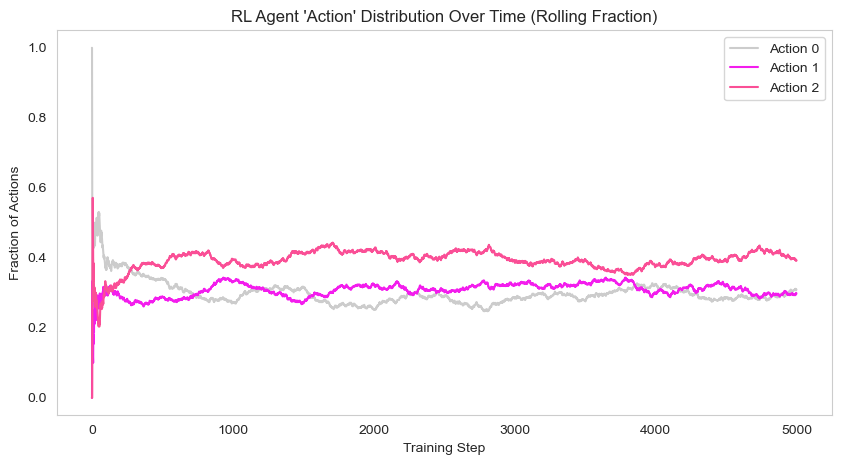

In [64]:
# 4) Plot the distribution of actions over time
plot_action_distribution_over_time(action_log)

#### First 500  Actions vs. Last 500 Actions

In [66]:
def plot_action_distribution_over_time(action_log, window_size=500, title="Action Distribution"):
    """
    Plots the fraction of each action (0,1,2) over time, using a rolling window of size 'window_size'.
    action_log: a list of integers representing the agent's actions over training steps.
    window_size: how many steps to include in the rolling average.
    title: custom title for the plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    actions_array = np.array(action_log)
    times = np.arange(len(actions_array))

    # Compute rolling fraction for each action
    rolling_props = {a: [] for a in [0, 1, 2]}
    for i in range(len(actions_array)):
        start = max(0, i - window_size)
        window = actions_array[start : i+1]
        for a in [0, 1, 2]:
            rolling_props[a].append(np.mean(window == a))

    # Define custom colors for each action (optional)
    color_map = {
        0: ppt_lightgrey,
        1: ppt_pink,
        2: ppt_rasp
    }

    plt.figure(figsize=(10, 5))
    for a in [0, 1, 2]:
        plt.plot(times, rolling_props[a], label=f"Action {a}", color=color_map[a])
    plt.title(title)
    plt.xlabel("Training Step")
    plt.ylabel(f"Fraction of Action in Last {window_size} Steps")
    plt.legend()
    plt.show()


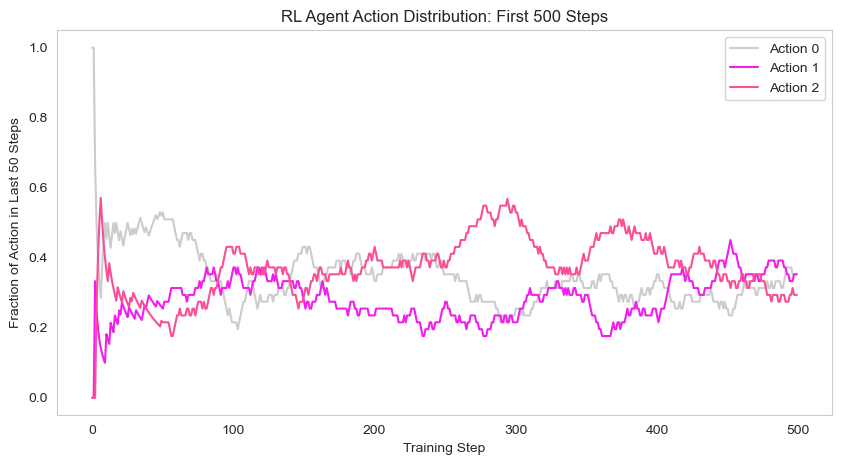

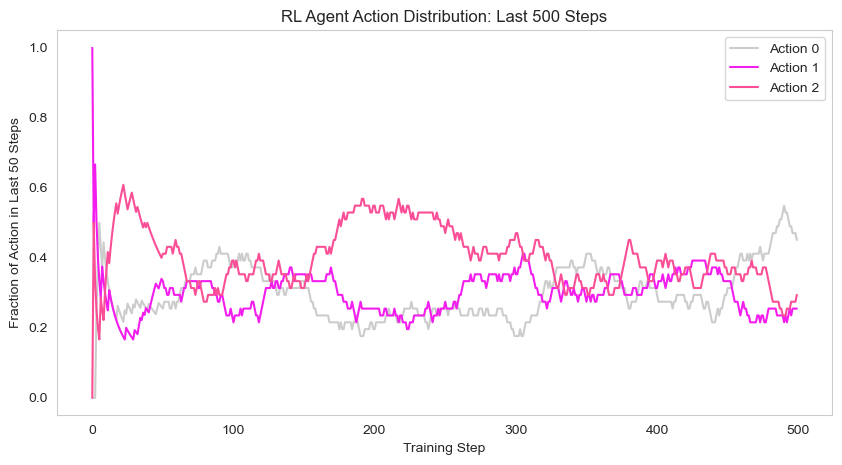

In [67]:
if __name__ == "__main__":
    # Suppose 'action_log' has length 10,000 from your RL training.

    # 1) Plot the FIRST 500 steps
    first_500_actions = action_log[:500]
    plot_action_distribution_over_time(
        first_500_actions,
        window_size=50,  # for example, you might pick 50 so you see more variation
        title="RL Agent Action Distribution: First 500 Steps"
    )

    # 2) Plot the LAST 500 steps
    last_500_actions = action_log[-500:]
    plot_action_distribution_over_time(
        last_500_actions,
        window_size=50,  # same or different rolling window
        title="RL Agent Action Distribution: Last 500 Steps"
    )

<br></br>

---
## Appendix: Additional Context and Explanations

---

### Cost Factor in the Model

In our model, we multiply the marketing spend by a **cost factor** to represent how spending translates into actual costs:

- **Formula:**  
  $
  \text{Cost} = \text{spend} \times \text{cost factor}
  $

- **Why Use a Cost actor?**  
  - The **cost factor** is a multiplier indicating the **cost per unit of spend**.  
  - If `cost_factor = 1.0`, cost = spend directly.  
  - If `cost_factor > 1.0`, costs grow faster than spend (e.g., expensive channels).  
  - If `cost_factor < 1.0`, costs grow more slowly than spend (e.g., very efficient or discounted channels).

**Example:**
- Spend = 5, Cost Factor = 1.0 → Cost = 5  
- Spend = 5, Cost Factor = 2.0 → Cost = 10

This flexibility lets us simulate **real-world marketing scenarios** where costs can vary widely based on the efficiency or overhead of marketing channels.

---

###  Diminishing Returns

Our model currently uses a **parabolic revenue function**:
$
\text{Revenue} = -(s - 5)^2 + 25
$
This peaks at `spend = 5` and decreases as we move away from 5. However, `true diminishing returns` typically refer to a scenario where each additional unit of spend yields a smaller incremental increase in revenue.

- **Parabolic vs. Diminishing Returns**  
  - `Parabolic`: Has a single peak (at spend=5) but doesn’t strictly model the *marginal* increase shrinking continuously.  
  - `Diminishing Returns`: Each extra dollar spent yields a smaller gain than the previous dollar, which can be captured by `logistic` or `logarithmic` functions.

**Logistic Function Example**:
$
\text{Revenue} = \frac{L}{1 + e^{-k(s - s_0)}}
$
Where:
- $( L $) is the maximum possible revenue,
- $( k $) is the rate of growth,
- $( s_0 $) is the inflection point.

In a `logistic` curve, the `marginal increase` in revenue decreases as spend grows, reflecting classic diminishing returns.

---

### Multiple Epochs in RL Training

When you train a reinforcement learning (RL) agent multiple times, you often refer to each training cycle as an `epoch`. Here’s how it works:

#### What Is an Epoch?

- An `epoch` is one complete training cycle with a certain number of episodes (e.g., 10 episodes).
- During each epoch, the agent explores different spending actions to maximize rewards (net profit).

**Example**:
- If you train for `5 epochs`, and each epoch has `10 episodes`, you effectively run 50 episodes of training, with the agent learning incrementally each epoch.

#### Winning Policy Per Epoch

- Within each epoch, the agent may try various strategies (actions).  
- At the end of an epoch, you can identify the `winning policy`—the strategy that yielded the highest total reward in that set of episodes.

#### Averaging Winning Policies

- After multiple epochs, you end up with several `winning policies`.  
- `Averaging` these policies can create a more `robust` solution, akin to cross-validation in supervised learning.

#### Confidence Intervals

- By comparing how winning policies vary across epochs, you can estimate `confidence intervals` around the final policy.  
- A `wide interval` suggests more variability; a `narrow interval` implies consistent performance.
- Training over multiple epochs and averaging the results helps ensure you’re not just picking a single “lucky” policy from one epoch but rather a `generalizable` strategy that performs reliably across different runs.

---
